In [1]:
import numpy as np
import os
import tifffile as tiff
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2024-07-03 12:22:57.150010: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 12:22:57.276149: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 12:22:59.567797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
import numpy as np
import rasterio
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_dataset(data_dir, img_size=(256, 256)):
    """
    Load dataset from specified directory.

    Parameters:
    - data_dir (str): Directory containing train, val, and test subdirectories.
    - img_size (tuple): Desired size of the image (height, width).

    Returns:
    - train_data (tuple): Tuple containing (X_train, y_train).
    - val_data (tuple): Tuple containing (X_val, y_val).
    - test_data (tuple): Tuple containing (X_test, y_test).
    """
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    test_dir = os.path.join(data_dir, 'test')

    # Load training data
    X_train, y_train = load_data_from_dir(os.path.join(train_dir, 'input'), os.path.join(train_dir, 'output'), img_size)
    # Load validation data
    X_val, y_val = load_data_from_dir(os.path.join(val_dir, 'input'), os.path.join(val_dir, 'output'), img_size)
    # Load test data
    X_test, y_test = load_data_from_dir(os.path.join(test_dir, 'input'), os.path.join(test_dir, 'output'), img_size)

    # Preprocess to handle NaN values
    X_train = preprocess_data(X_train)
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def preprocess_data(images):
    """
    Preprocesses input images to handle NaN values.

    Parameters:
    - images (numpy.ndarray): Array of input images.

    Returns:
    - images (numpy.ndarray): Processed array of input images.
    """
    # Replace NaN values with 0
    images[np.isnan(images)] = 0

    return images

def load_data_from_dir(input_dir, output_dir, img_size):
    """
    Load data (images and labels) from input and output directories.

    Parameters:
    - input_dir (str): Directory containing input images.
    - output_dir (str): Directory containing output images.
    - img_size (tuple): Desired size of the image (height, width).

    Returns:
    - images (numpy.ndarray): Array of loaded input images.
    - labels (numpy.ndarray): Array of corresponding output images.
    """
    images = []
    labels = []

    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            # Load input image (X)
            input_path = os.path.join(input_dir, filename)
            img = load_tiff_image(input_path, img_size)
            images.append(img)

            # Load corresponding output image (y)
            output_filename = filename.replace('.tif', '_cl.tif')
            output_path = os.path.join(output_dir, output_filename)
            label = load_tiff_image(output_path, img_size, is_label=True)
            label[np.isnan(label)] = 0 
            labels.append(label)

    if images and labels:
        images = np.array(images)
        labels = np.array(labels)

    return images, labels

def load_tiff_image(path, img_size, is_label=False):
    """
    Load a TIFF image from specified path.

    Parameters:
    - path (str): Path to the TIFF image.
    - img_size (tuple): Desired size of the image (height, width).
    - is_label (bool): Whether the image is a label image.

    Returns:
    - img (numpy.ndarray): Loaded image as a numpy array.
    """
    with rasterio.open(path) as src:
        img = src.read()

    # Reshape and resize if necessary
    img = img.transpose(1, 2, 0)  # Change from bands x height x width to height x width x bands
    img = img[:img_size[0], :img_size[1], :]  # Resize to desired size

    if is_label:
        # Convert label image to binary classification (1 for Marine Debris, 0 for others)
        img = (img == 1).astype(np.uint8)  # Assuming Marine Debris class is encoded as 1

    return img

# Example usage:
data_dir = 'MARIDA'
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_dataset(data_dir)

print(f"Training data: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
print(f"Validation data: X_val shape = {X_val.shape}, y_val shape = {y_val.shape}")
print(f"Testing data: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")


2024-07-05 09:57:08.388863: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-05 09:57:08.438302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-05 09:57:09.386298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Training data: X_train shape = (694, 256, 256, 11), y_train shape = (694, 256, 256, 1)
Validation data: X_val shape = (328, 256, 256, 11), y_val shape = (328, 256, 256, 1)
Testing data: X_test shape = (359, 256, 256, 11), y_test shape = (359, 256, 256, 1)


In [19]:
X = np.reshape(X_train, (256*256*694, 11))
Y = np.reshape(y_train, (256*256*694, 1))
print(X.shape)

(45481984, 11)


In [11]:
X_test.shape

(359, 256, 256, 11)

In [10]:
x_val = np.reshape(X_val, (256*256*328, 11))
Y_val = np.reshape(y_val, (256*256*328, 1))
print(Y_val.shape)

(21495808, 1)


In [13]:
x_test = np.reshape(X_test, (256*256*359, 11))
Y_test = np.reshape(y_test, (256*256*359, 1))
print(Y_test.shape)

(23527424, 1)


In [41]:
type(Y)
# Assuming Y is a column vector and X is a 2D array (rows x columns)

# Y.info

numpy.ndarray

In [29]:
import numpy as np

# Sample data creation
# np.random.seed(0)
# X_train = np.random.normal(loc=0, scale=1, size=100)  # Example X_train (normally distributed)
# Y_train = np.random.randint(0, 2, size=100)  # Example Y_train (binary: 0 or 1)

# Filter X_train based on Y_train where Y_train == 1
filtered_X_1 = X[Y.flatten() == 1]
filtered_X_0 = X[Y.flatten() == 0]

# Print or use filtered_X as needed
# print("Filtered X_train where Y_train == 1:")
# print(filtered_X)


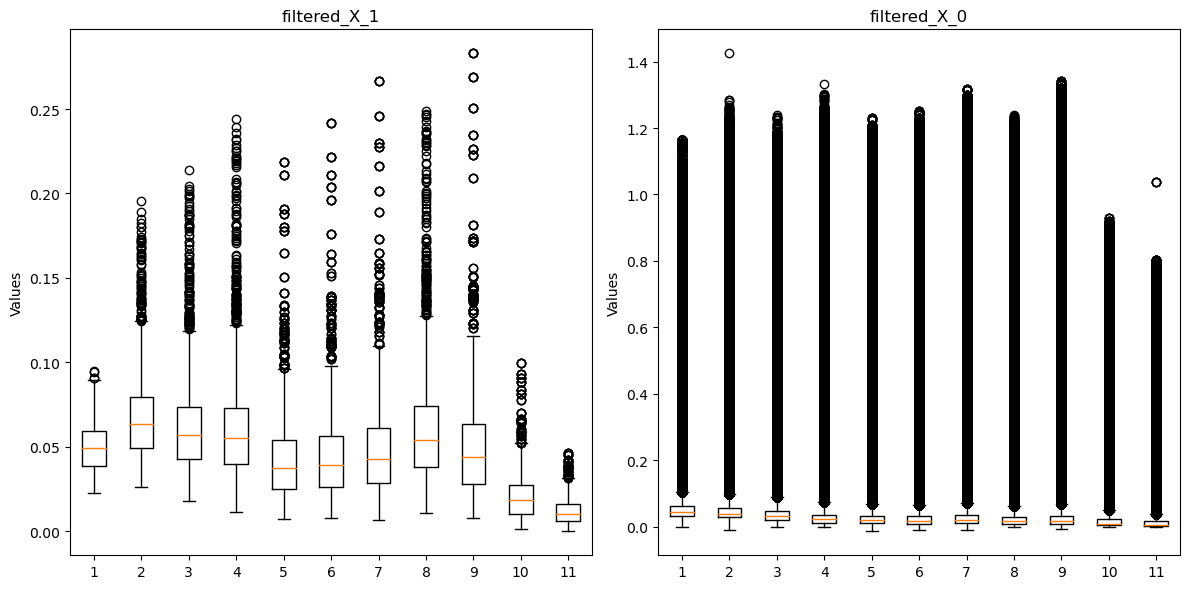

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data creation
np.random.seed(0)
# X_train = np.random.normal(loc=0, scale=1, size=100)  # Example X_train (normally distributed)
# Y_train = np.random.normal(loc=5, scale=2, size=100)  # Example Y_train (normally distributed)

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Box plot for X_train
axs[0].boxplot(filtered_X_1)
axs[0].set_title('filtered_X_1')
axs[0].set_ylabel('Values')

# Box plot for Y_train
axs[1].boxplot(filtered_X_0)
axs[1].set_title('filtered_X_0')
axs[1].set_ylabel('Values')

# Display the plot
plt.tight_layout()
plt.show()


In [33]:
import pandas as pd

In [34]:
df_1= pd.DataFrame(filtered_X_1)

In [37]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1943 entries, 0 to 1942
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1943 non-null   float32
 1   1       1943 non-null   float32
 2   2       1943 non-null   float32
 3   3       1943 non-null   float32
 4   4       1943 non-null   float32
 5   5       1943 non-null   float32
 6   6       1943 non-null   float32
 7   7       1943 non-null   float32
 8   8       1943 non-null   float32
 9   9       1943 non-null   float32
 10  10      1943 non-null   float32
dtypes: float32(11)
memory usage: 83.6 KB


In [39]:
df_1.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,1943.000000,1943.000000,1943.000000,1943.000000,1943.000000,1943.000000,1943.000000,1943.000000,1943.000000,1943.000000,1943.000000
mean,0.050086,0.067390,0.062013,0.062116,0.044683,0.046898,0.051129,0.062306,0.052793,0.021037,0.011942
std,0.014475,0.026171,0.029961,0.035749,0.030099,0.032188,0.035936,0.037430,0.038496,0.015260,0.008021
min,0.022640,0.026505,0.017880,0.011677,0.007020,0.007609,0.006729,0.010915,0.007990,0.001457,-0.000058
25%,0.038901,0.049499,0.042596,0.039625,0.025296,0.026254,0.028406,0.037976,0.028123,0.010492,0.006056
50%,0.049543,0.063533,0.056961,0.055481,0.037609,0.039182,0.042512,0.053857,0.043922,0.018423,0.010260
75%,0.059466,0.079416,0.073298,0.072844,0.053774,0.056238,0.061202,0.074051,0.063347,0.027207,0.016259
max,0.094668,0.195569,0.213804,0.243798,0.218750,0.241753,0.266846,0.248551,0.283025,0.099833,0.046273


In [40]:
df_0= pd.DataFrame(filtered_X_0)
df_0.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,4.548004e+07,4.548004e+07,4.548004e+07,4.548004e+07,4.548004e+07,4.548004e+07,4.548004e+07,4.548004e+07,4.548004e+07,4.548004e+07,4.548004e+07
mean,5.197600e-02,4.783894e-02,4.056709e-02,3.163438e-02,2.972548e-02,3.457382e-02,3.874998e-02,3.436322e-02,3.921068e-02,2.358124e-02,1.588822e-02
std,4.639751e-02,4.672051e-02,4.589459e-02,4.829313e-02,4.804760e-02,6.318147e-02,7.448573e-02,6.973171e-02,8.084711e-02,4.962075e-02,3.413977e-02
min,0.000000e+00,-1.025861e-02,0.000000e+00,-1.488856e-03,-1.440220e-02,-1.004743e-02,-1.050028e-02,-2.050408e-03,-6.805487e-03,-4.347653e-04,-5.944580e-05
25%,3.193294e-02,2.781102e-02,1.970199e-02,1.139753e-02,9.444582e-03,9.044676e-03,9.486201e-03,7.658015e-03,8.546154e-03,3.685892e-03,2.562758e-03
50%,4.270765e-02,3.821329e-02,3.098554e-02,2.198265e-02,1.875282e-02,1.782541e-02,1.882613e-02,1.542243e-02,1.745130e-02,9.211080e-03,6.157906e-03
75%,6.065632e-02,5.648956e-02,4.758769e-02,3.616117e-02,3.282570e-02,3.186612e-02,3.377565e-02,2.927066e-02,3.252947e-02,2.189279e-02,1.625681e-02
max,1.162700e+00,1.425148e+00,1.240489e+00,1.332910e+00,1.230685e+00,1.251744e+00,1.317625e+00,1.239644e+00,1.343012e+00,9.284287e-01,1.037386e+00


In [44]:
np.unique(Y, return_counts=True)

(array([0, 1], dtype=uint8), array([45480041,     1943]))

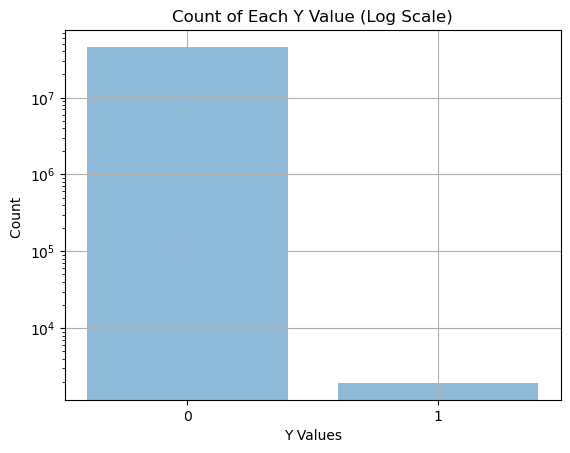

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Given data from np.unique(Y, return_counts=True)
unique_values = np.array([0, 1])
counts = np.array([45480041, 1943])

# Plotting with logarithmic scale
plt.bar(unique_values, counts, align='center', alpha=0.5)
plt.xlabel('Y Values')
plt.ylabel('Count ')
plt.title('Count of Each Y Value (Log Scale)')
plt.yscale('log')  # Use logarithmic scale for y-axis

# Customizing X ticks and labels
plt.xticks(unique_values, ['0', '1'])

plt.grid(True)
plt.show()


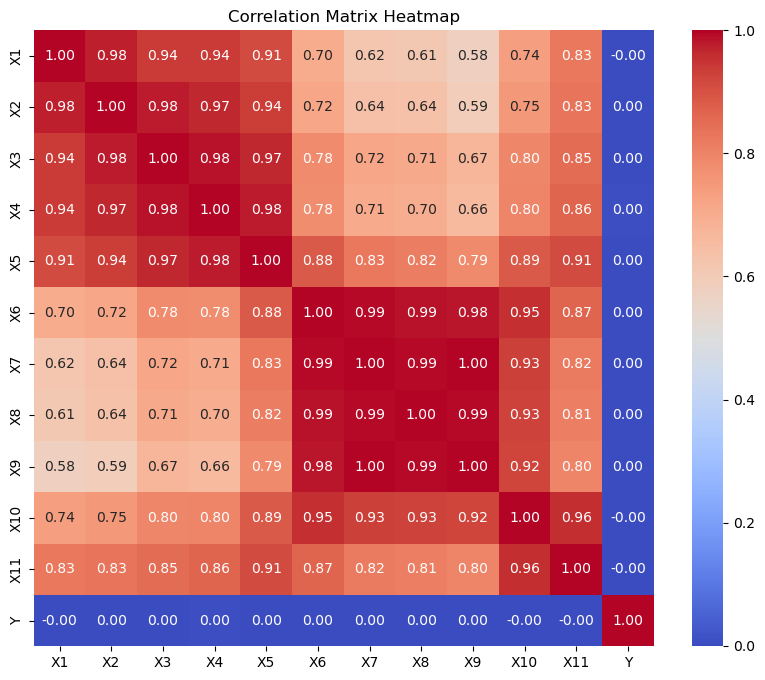

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = np.corrcoef(np.hstack((X, Y)), rowvar=False)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f",
            xticklabels=['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'Y'],
            yticklabels=['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'Y'])
plt.title('Correlation Matrix Heatmap')
plt.show()
#  Band 5 (X5) , band 8(X8) , band 10 (X10)

In [56]:
# import numpy as np
# from sklearn.feature_selection import mutual_info_regression

# # Example data (replace with your actual data)
# X = np.random.randn(1000, 11)  # Example array for X (1000 samples, 11 features)
# Y = np.random.randn(1000)      # Example array for Y (1000 samples)

# # Calculate mutual information for each column in X with respect to Y
# mi_scores = []
# for i in range(X.shape[1]):
#     mi = mutual_info_regression(X[:, i:i+1], Y)
#     mi_scores.append(mi[0])

# # Print or use mi_scores as needed
# for i in range(len(mi_scores)):
#     print(f"Mutual Information for X{i+1}: {mi_scores[i]}")


/home/isro/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/isro/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/isro/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/isro/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

Mutual Information for X1: 0
Mutual Information for X2: 9.938543916732101e-06
Mutual Information for X3: 0
Mutual Information for X4: 0.0002468588922859283
Mutual Information for X5: 0
Mutual Information for X6: 0.00013153177593849819
Mutual Information for X7: 0.00012388717551203854
Mutual Information for X8: 0.0003635467645377588
Mutual Information for X9: 0.00011893680962060671
Mutual Information for X10: 0.0002484861425458007
Mutual Information for X11: 3.312874154737244e-05


In [59]:
for x in mi_scores:
    print(x*1000)


0
0.009938543916732101
0
0.24685889228592828
0
0.13153177593849819
0.12388717551203854
0.3635467645377588
0.11893680962060671
0.2484861425458007
0.03312874154737244


In [60]:
# Save output to a file
output_file = "mutual_info_scores.txt"
with open(output_file, 'w') as f:
    for i in range(len(mi_scores)):
        f.write(f"Mutual Information for X{i+1}: {mi_scores[i]}\n")

print(f"Output saved to file '{output_file}'")

Output saved to file 'mutual_info_scores.txt'
